## Moving the Learning algorithms (VQE + QCNN) on JAX GPU

In [6]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import os, sys
import time

import copy
import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn

In [7]:
N = 8
J = 1

In [8]:
n_epochs = 100000
lr = 0.15
l_steps = 100
reg = 100

In [9]:
device_jax = qml.device("default.qubit.jax", wires = N, shots = None)
device_mix = qml.device("default.mixed", wires = N, shots = None) 
device_def = qml.device("default.qubit", wires = N, shots = None)

# VQE

+--- PARAMETERS ---+
step_size      = 0.15 (Step size of the optimizer)
n_epochs       = 100000 (# epochs for the other GSs)
N              = 8 (Number of spins of the system)
+--- CIRCUIT ---+
0: ──RY(0.00)──RX(8.00)───||─╭IsingZZ(16.00)────────────────────────────────────────────────
1: ──RY(1.00)──RX(9.00)───||─╰IsingZZ(16.00)─╭IsingZZ(17.00)────────────────────────────────
2: ──RY(2.00)──RX(10.00)──||─────────────────╰IsingZZ(17.00)─╭IsingZZ(18.00)────────────────
3: ──RY(3.00)──RX(11.00)──||─────────────────────────────────╰IsingZZ(18.00)─╭IsingZZ(19.00)
4: ──RY(4.00)──RX(12.00)──||─────────────────────────────────────────────────╰IsingZZ(19.00)
5: ──RY(5.00)──RX(13.00)──||────────────────────────────────────────────────────────────────
6: ──RY(6.00)──RX(14.00)──||────────────────────────────────────────────────────────────────
7: ──RY(7.00)──RX(15.00)──||────────────────────────────────────────────────────────────────

───────────────────────────────────────────────────||──RY(23.

Cost: 0.0076861572451889515: 100%|█████| 100000/100000 [10:01<00:00, 166.22it/s]


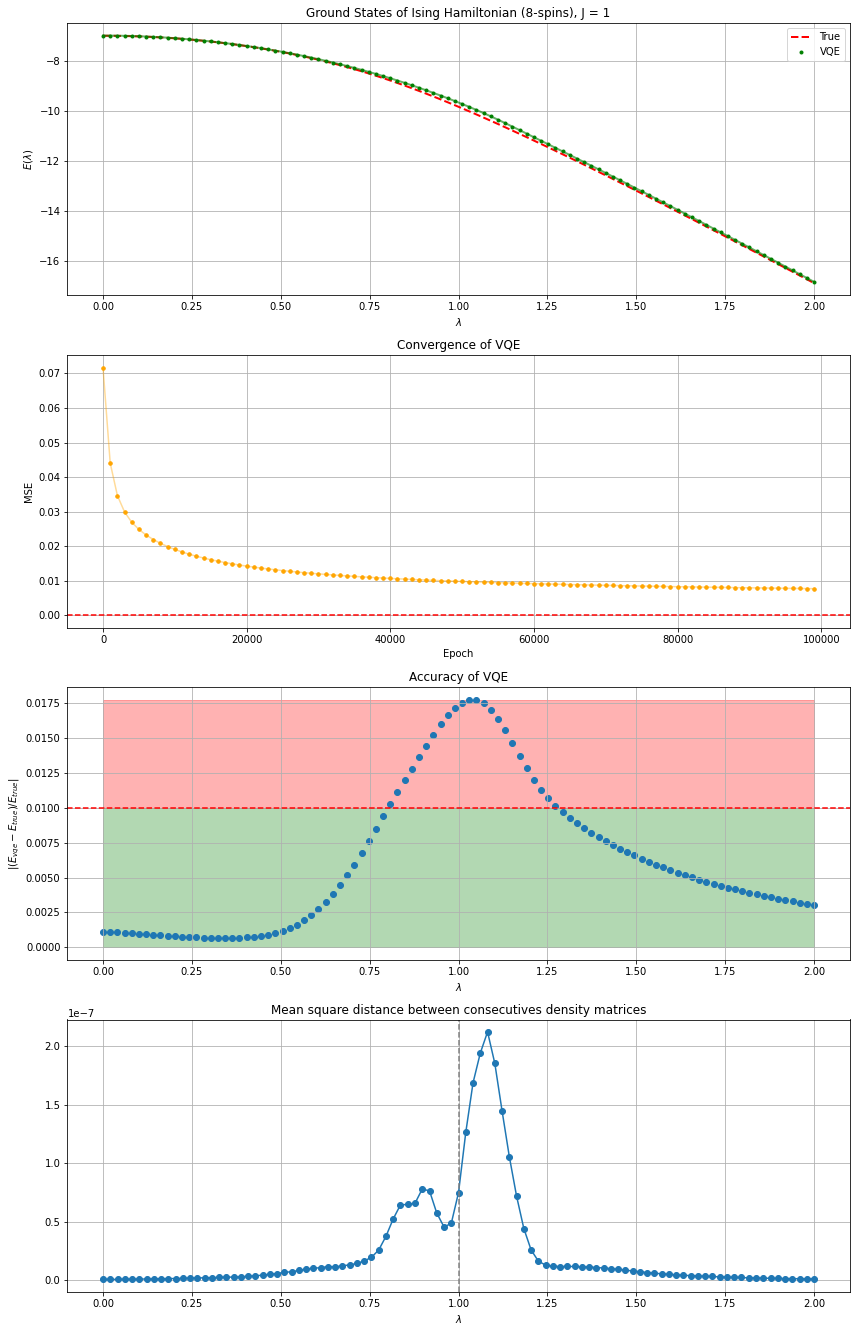

In [10]:
vqe_e, params, ys = vqe.jax_train(lr, n_epochs, N, J, l_steps, device_jax, vqe.vqe_circuit, reg = reg, plots = True, circuit = True)

In [11]:
vqe_data_x = params 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, '../vqe_states_job/0noiseN'+str(N)+'.job')

/home/saverio/Desktop/CERN/code/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


['../vqe_states_job/0noiseN8.job']

In [12]:
# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/0noiseN'+str(N)+'.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []
X, Y             = [], []
for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [26]:
qcnn_circuit = qcnn.qcnn_circuit
vqe_circuit = vqe.vqe_circuit

+-- PARAMETERS ---+
a factor   = 0.05 ('a' coefficient of the optimizer)
epochs     = 3000 (# epochs for learning)
N          = 8 (Number of spins of the system)


Cost: 0.24812018871307373: 100%|███████████| 3000/3000 [00:21<00:00, 136.43it/s]


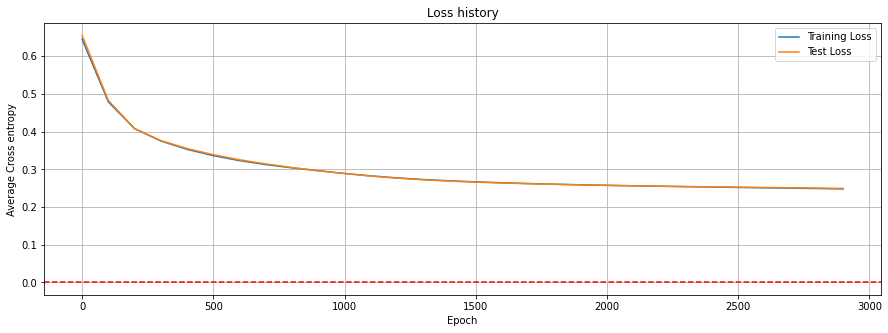

In [39]:
loss, params = qcnn.jax_train(3000, 0.05, N, device_jax, vqe_circuit, qcnn_circuit, X_train, Y_train, X_test, Y_test, plot = True, info = True)

In [42]:
X = jnp.array(X)
Y = jnp.array(Y)

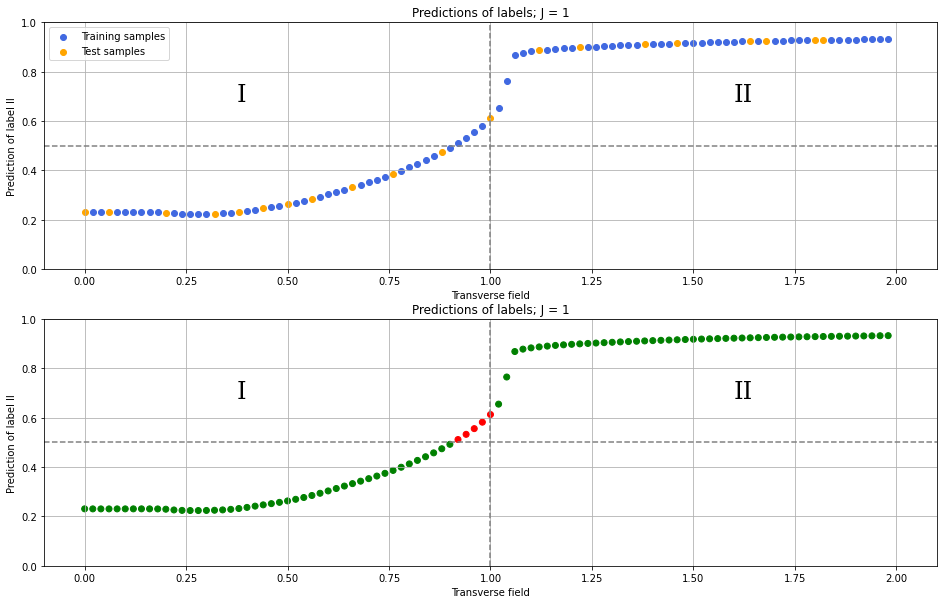

In [43]:
qcnn.jax_plot_results_classification(X, Y, train_index, params, N, device_jax, vqe_circuit, qcnn_circuit)
